# Pokemon Dataset
https://huggingface.co/datasets/diffusers/pokemon-gpt4-captions


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from datasets import load_dataset
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import nltk
import matplotlib.pyplot as plt
import gensim.downloader as api
import numpy as np
from textwrap import wrap
nltk.download('punkt')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Exploratory Dataset Analysis

Loading Word2Vec embeddings
Word2Vec embeddings loaded.
Displaying sample images from training set:


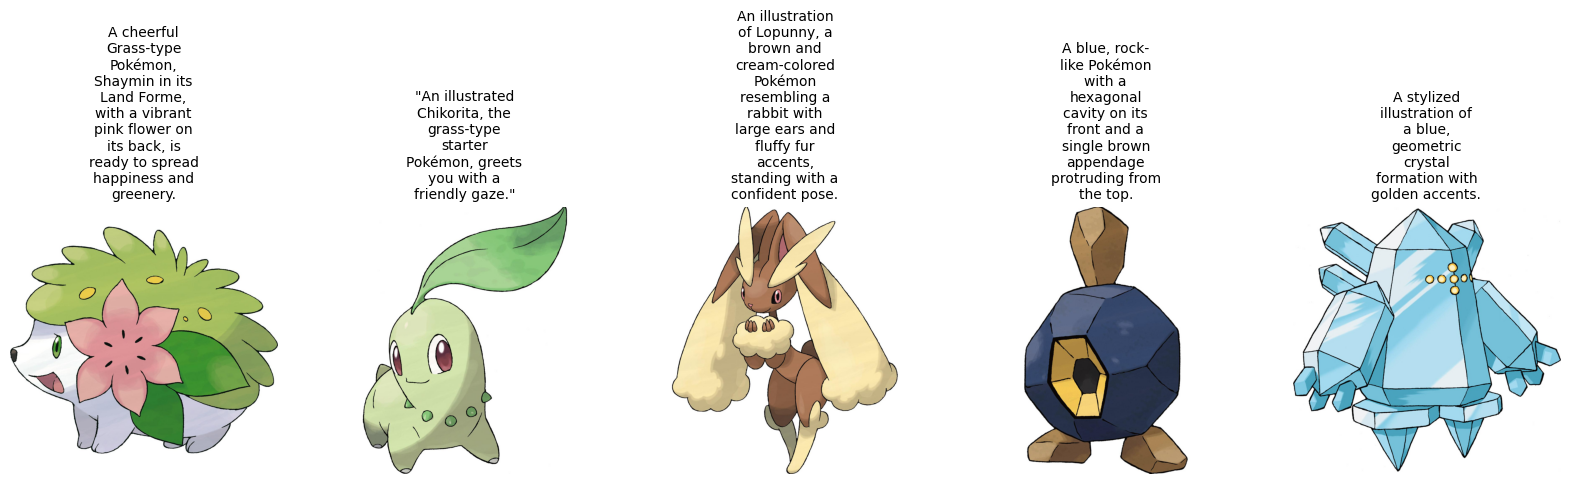


Dataset Statistics:
Total training samples: 666
Total testing samples: 167
Average caption length: 22.43 words
Max caption length: 41 words
Min caption length: 8 words


In [2]:
# use word2vec as base to increase embedding knowledge bvase
print("Loading Word2Vec embeddings")
word2vec = api.load('word2vec-google-news-300')
print("Word2Vec embeddings loaded")

def show_images_from_dataset(dataset, num_samples=5):
    plt.figure(figsize=(20, 15))
    for i in range(num_samples):
        image = np.array(dataset[i]["image"])
        caption = dataset[i]["text"]
        ax = plt.subplot(1, num_samples, i + 1)
        ax.set_title("\n".join(wrap(caption, 15)), fontsize=10)
        plt.imshow(image)
        plt.axis("off")
    plt.show()

dataset = load_dataset("diffusers/pokemon-gpt4-captions")

train_test_split = dataset['train'].train_test_split(test_size=0.2, seed=88)
train_dataset_raw = train_test_split['train']
test_dataset_raw = train_test_split['test']

show_images_from_dataset(train_dataset_raw, num_samples=5)

print("\nDataset Statistics")
print(f"Total training samples: {len(train_dataset_raw)}")
print(f"Total testing samples: {len(test_dataset_raw)}")
caption_lengths = [len(nltk.word_tokenize(data['text'].lower())) for data in train_dataset_raw]
print(f"Average caption length: {np.mean(caption_lengths):.2f} words")
print(f"Max caption length: {max(caption_lengths)} words")
print(f"Min caption length: {min(caption_lengths)} words")


## Image Feature Extraction
- Loads a pre-trained ResNet-50 model from and initialize with weights trained on ImageNet
- Use all layers of ResNet-50 except the last layer (fully connected layer)
- Freezes the weights, preventing them from being updated during backpropagation, which saves computation and leverages pre-trained features
- Input is tensor of shape (batch_size, 3, 224, 224)
- Output shape is (batch_size, 2048, 1, 1) with 2048 features

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])
        for param in self.resnet.parameters():
            param.requires_grad = False
    
    def forward(self, images):
        features = self.resnet(images)
        return features.view(features.size(0), -1)

## Sequence Model for Language Processing

- Takes in the dataset, image transformation and a frequency threshold (set to 0 to include all words)
- Transforms and extracts captions, then builds a vocabulary by counting words in lowercased, NLTK-tokenized captions
    - Includes special tokens and all words regardless of frequency
    - Special tokens are used to manage the captions for training and inference
    - PAD ensures all captions in a batch have the same length for efficient processing
        - Model ignores PAD tokens during loss calculation
        - Variable-length captions would otherwise cause shape mismatches in batched tensor operations
    - START marks the beginning of a caption sequence
        - Signals the model to start generating or processing a caption, providing a consistent starting point
    - END marks the end of a caption sequence
        - Indicates the completion of a caption, allowing the model to learn when to stop generating words
    - UNK represents words not in the vocabulary
        - Ensures the model can process any input word, even if it’s not in the vocabulary, maintaining robustness
- Creates word2idx and idx2word dictionaries for mapping words to indices and vice versa and stores indices for special tokens
- An embedding matrix is initialized with 300-dimensional Word2Vec embeddings for known words and random embeddings for others



In [13]:
class PokemonDataset(Dataset):
    def __init__(self, dataset, transform=None, freq_threshold=0):
        self.dataset = dataset
        self.transform = transform
        self.captions = [data['text'] for data in dataset]
        
        # vocab for sequence generation
        word_freq = Counter()
        for caption in self.captions:
            word_freq.update(nltk.word_tokenize(caption.lower()))
        self.vocab = ['<PAD>', '<START>', '<END>', '<UNK>']
        self.vocab.extend([word for word, freq in word_freq.items() if freq >= freq_threshold])
        self.word2idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        self.pad_idx = self.word2idx['<PAD>']
        self.start_idx = self.word2idx['<START>']
        self.end_idx = self.word2idx['<END>']
        self.unk_idx = self.word2idx['<UNK>']
        
        #  embedding matrix for LSTM input
        embed_size = 300
        self.embedding_matrix = torch.zeros(len(self.vocab), embed_size)
        for word, idx in self.word2idx.items():
            if word in word2vec:
                self.embedding_matrix[idx] = torch.tensor(word2vec[word])
            else:
                self.embedding_matrix[idx] = torch.randn(embed_size)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image = self.dataset[idx]['image'].convert('RGB')
        caption = self.dataset[idx]['text'].lower()
        if self.transform:
            image = self.transform(image)
        tokens = ['<START>'] + nltk.word_tokenize(caption) + ['<END>']
        caption_idx = [self.word2idx.get(token, self.unk_idx) for token in tokens]
        return image, torch.tensor(caption_idx)

## Combining Image and Text Data
- Decoder is a neural network designed to generate captions for images using input features and captions
- Embedding layer converts words into dense vectors using a pre-trained embedding matrix
- LSTM layer is a recurrent network that processes sequences
- Linear layer maps LSTM outputs to the vocabulary size for word predictions
- For forward pass, convert the input captions into vector representations, excluding the END token
- The LSTM’s hidden and cell states are first initialized using image features
- Next word can be predicted by processesing the embedded captions through the LSTM to predict

In [14]:
class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, embedding_matrix, num_layers=1):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.fc_h = nn.Linear(2048, hidden_size)  # map CNN features to LSTM hidden state
        self.fc_c = nn.Linear(2048, hidden_size)  # map CNN features to LSTM cell state
    
    def forward(self, features, captions):
        # embed captions (excluding <END> token)
        embeddings = self.embed(captions[:, :-1])  # (batch_size, seq_len-1, embed_size)
        
        # initialize LSTM hidden and cell states with CNN features
        h0 = self.fc_h(features).unsqueeze(0)  # (num_layers, batch_size, hidden_size)
        c0 = self.fc_c(features).unsqueeze(0)  # (num_layers, batch_size, hidden_size)
        
        # generate sequence of words
        outputs, _ = self.lstm(embeddings, (h0, c0))  # (batch_size, seq_len-1, hidden_size)
        outputs = self.linear(outputs)  # (batch_size, seq_len-1, vocab_size)
        return outputs

## Training

In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # follow iamgenet std dev and mean
])

train_dataset = PokemonDataset(train_dataset_raw, transform=transform, freq_threshold=2)
test_dataset = PokemonDataset(test_dataset_raw, transform=transform, freq_threshold=2)

def collate_fn(batch):
    images, captions = zip(*batch)
    images = torch.stack(images, 0)
    captions = pad_sequence(captions, batch_first=True, padding_value=train_dataset.pad_idx)
    return images, captions

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

vocab_size = len(train_dataset.vocab)
embed_size = 300
hidden_size = 512

encoder = Encoder().to(device)
decoder = Decoder(embed_size, hidden_size, vocab_size, train_dataset.embedding_matrix).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.pad_idx)
optimizer = optim.Adam(decoder.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    total_loss = 0
    for images, captions in train_loader:
        images = images.to(device)
        captions = captions.to(device)
        features = encoder(images)
        outputs = decoder(features, captions)
        targets = captions[:, 1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.contiguous().view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

torch.save(encoder.state_dict(), 'encoder.pt')
torch.save(decoder.state_dict(), 'decoder.pt')
print("Models saved as 'encoder.pt' and 'decoder.pt'")

Epoch [1/100], Loss: 4.8653
Epoch [2/100], Loss: 3.9175
Epoch [3/100], Loss: 3.6271
Epoch [4/100], Loss: 3.4205
Epoch [5/100], Loss: 3.2517
Epoch [6/100], Loss: 3.1012
Epoch [7/100], Loss: 2.9693
Epoch [8/100], Loss: 2.8564
Epoch [9/100], Loss: 2.7465
Epoch [10/100], Loss: 2.6405
Epoch [11/100], Loss: 2.5484
Epoch [12/100], Loss: 2.4586
Epoch [13/100], Loss: 2.3756
Epoch [14/100], Loss: 2.3032
Epoch [15/100], Loss: 2.2113
Epoch [16/100], Loss: 2.1382
Epoch [17/100], Loss: 2.0498
Epoch [18/100], Loss: 1.9717
Epoch [19/100], Loss: 1.8938
Epoch [20/100], Loss: 1.8048
Epoch [21/100], Loss: 1.7304
Epoch [22/100], Loss: 1.6506
Epoch [23/100], Loss: 1.5722
Epoch [24/100], Loss: 1.4960
Epoch [25/100], Loss: 1.4267
Epoch [26/100], Loss: 1.3407
Epoch [27/100], Loss: 1.2755
Epoch [28/100], Loss: 1.2062
Epoch [29/100], Loss: 1.1399
Epoch [30/100], Loss: 1.0704
Epoch [31/100], Loss: 1.0047
Epoch [32/100], Loss: 0.9367
Epoch [33/100], Loss: 0.8854
Epoch [34/100], Loss: 0.8224
Epoch [35/100], Loss: 0

## Testing

Sample 1 - Generated Caption: a stylized illustration of a butterfly with large blue and brown wings , a pointed and large patterned on its
Sample 1 - Ground Truth Caption: a , star-shaped illustration of a pokémon with a surrounded by a yellow and beige body .
Sample 2 - Generated Caption: a vibrant illustration of <UNK> , a blue and blue pokémon , depicted with its purple body , purple accents
Sample 2 - Ground Truth Caption: a blue and yellow aquatic pokémon with sharp claws and prepares for battle .
Sample 3 - Generated Caption: a colorful <UNK> , a dual-type <UNK> pokémon , stands <UNK> with its <UNK> abilities and skull <UNK> , ready
Sample 3 - Ground Truth Caption: a stylized illustration of a , a bird-like pokémon characterized by its sleek blue plumage and red , poised as if ready to take flight .
Sample 4 - Generated Caption: a cheerful pink , balloon-like creature with a cute swirl on its forehead and a blue orb at its belly
Sample 4 - Ground Truth Caption: a fluffy , cloud-

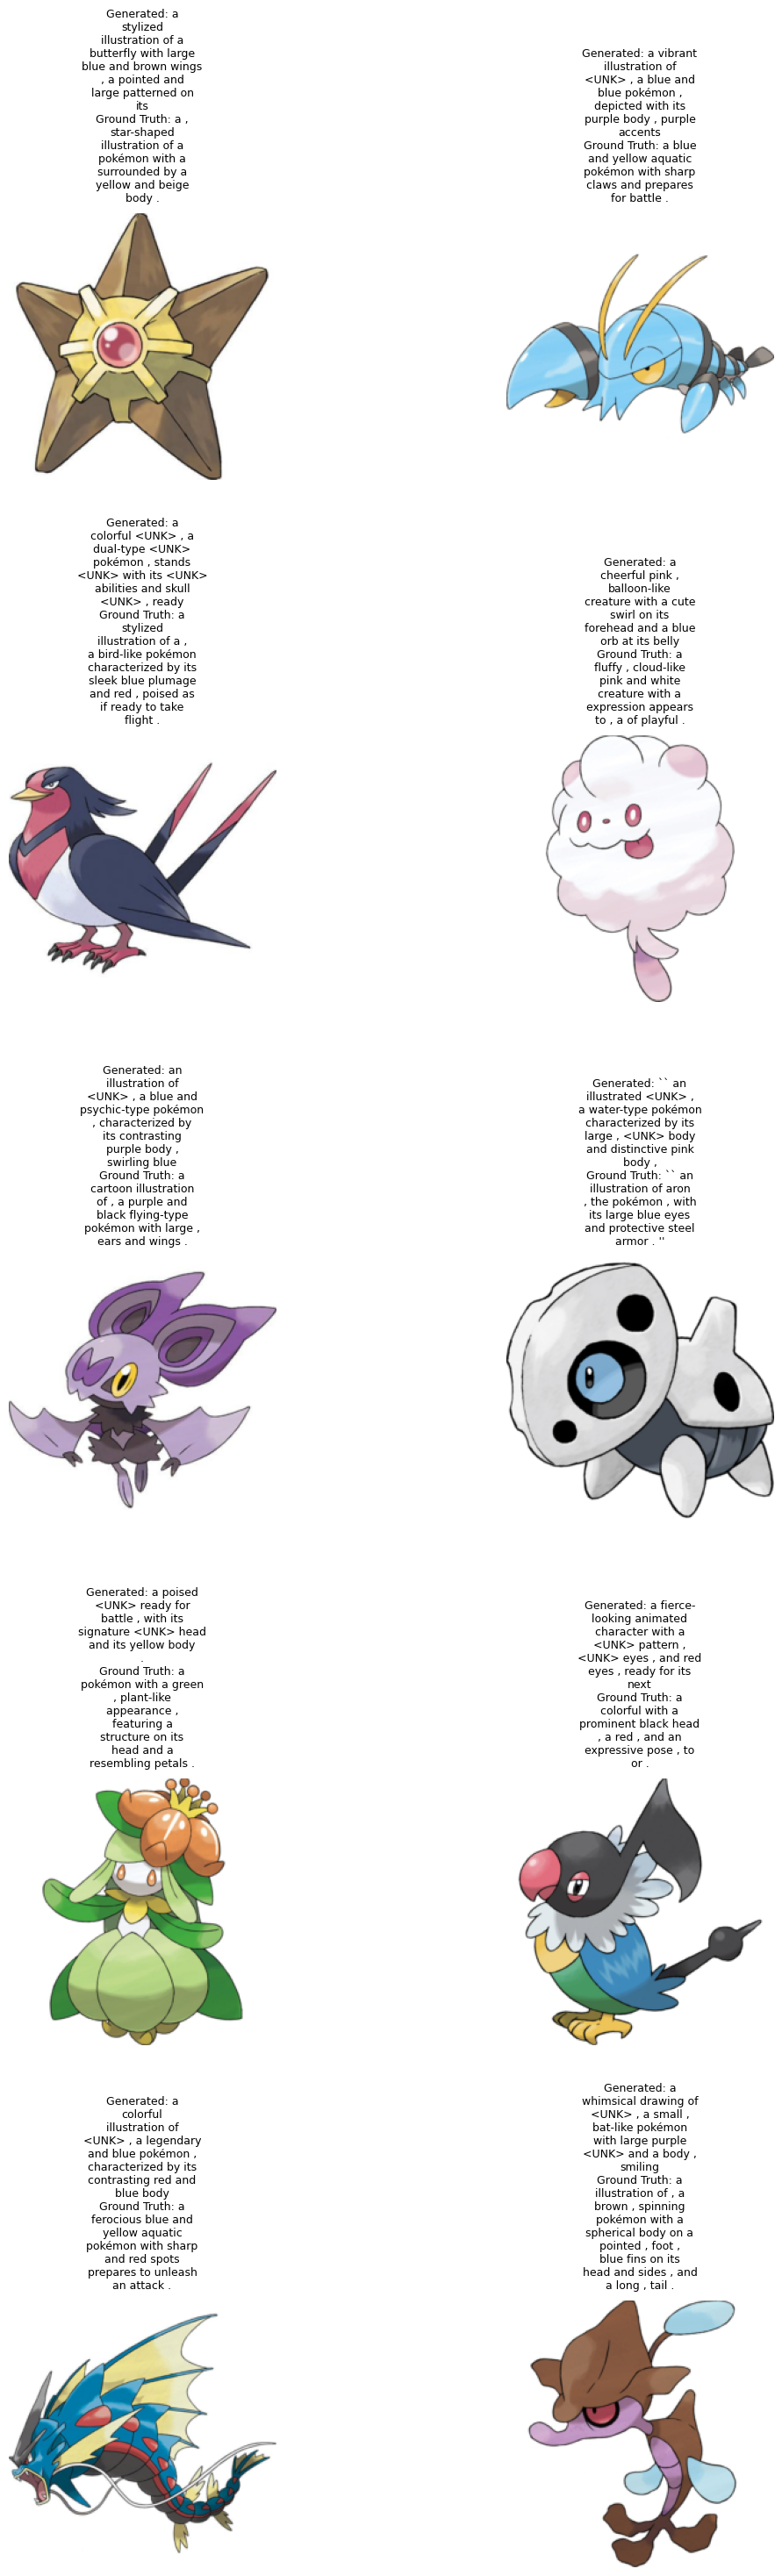

In [19]:
def generate_caption(encoder, decoder, image, max_length=20):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        features = encoder(image)
        h = decoder.fc_h(features).unsqueeze(0)
        c = decoder.fc_c(features).unsqueeze(0)
        caption = []
        input_word = torch.tensor([train_dataset.start_idx]).to(device)
        for _ in range(max_length):
            embeddings = decoder.embed(input_word).unsqueeze(1)
            output, (h, c) = decoder.lstm(embeddings, (h, c))
            output = decoder.linear(output.squeeze(1))
            
            # mask <UNK> by setting its probability to negative infinity
            # output[:, train_dataset.unk_idx] = float('-inf')
            
            predicted = output.argmax(1)
            word_idx = predicted.item()
            if word_idx == train_dataset.end_idx:
                break
            caption.append(word_idx)
            input_word = predicted
        return ' '.join([train_dataset.idx2word[idx] for idx in caption])

def denormalize(image_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image = image_tensor.cpu() * std + mean
    image = image.clamp(0, 1)
    return image

num_samples = 10
fig, axes = plt.subplots(5, 2, figsize=(12, 30))
axes = axes.flatten()

for i in range(num_samples):
    test_image, test_caption_idx = test_dataset[i]
    generated_caption = generate_caption(encoder, decoder, test_image)
    
    ground_truth_caption = ' '.join([
        test_dataset.idx2word[idx.item()] 
        for idx in test_caption_idx 
        if idx.item() not in [test_dataset.start_idx, test_dataset.end_idx, test_dataset.pad_idx, test_dataset.unk_idx]
    ])
    
    print(f"Sample {i+1} - Generated Caption: {generated_caption}")
    print(f"Sample {i+1} - Ground Truth Caption: {ground_truth_caption}")
    
    image = denormalize(test_image)
    axes[i].imshow(image.permute(1, 2, 0))
    
    wrapped_generated = "\n".join(wrap(f"Generated: {generated_caption}", width=20))
    wrapped_ground_truth = "\n".join(wrap(f"Ground Truth: {ground_truth_caption}", width=20))
    axes[i].set_title(f"{wrapped_generated}\n{wrapped_ground_truth}", fontsize=9, pad=10)
    axes[i].axis('off')

plt.tight_layout(pad=3.0)
plt.show()